### STEP 8. GAN 훈련과정 개선하기 
- idea
    - 입력 이미지의 해상도를 올려 generator 를 통해 생성된 이미지 개선하기
    - augmentation 을 이용해 train 효과 높이기
    - 모델을 얕게 쌓고, epoch 을 늘리기 -> 모델을 얕게 쌓는것이 정확히 어떤 점에서 학습과정에 도움이 되는지는 정확히 파악하지 못함. 많은 사람들의 경험을 통해나온 결과일 것으로 추정

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print('tensorflow',tf.__version__)

tensorflow 2.6.0


In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [3]:
print('max pixel:',train_x.max())
print('min pixel:',train_x.min())

max pixel: 255
min pixel: 0


In [4]:
train_x = (train_x - 127.5)/127.5
# normalize image into [-1,1]

print('max pixel:',train_x.max())
print('min pixel:',train_x.min())

max pixel: 1.0
min pixel: -1.0


In [5]:
from keras.preprocessing.image import ImageDataGenerator

# set up image augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
    #zoom_range=0.3
    )
datagen.fit(train_x)

In [6]:
train_x = train_x.reshape(train_x.shape[0],32,32,3).astype('float32')
train_x.shape

(50000, 32, 32, 3)

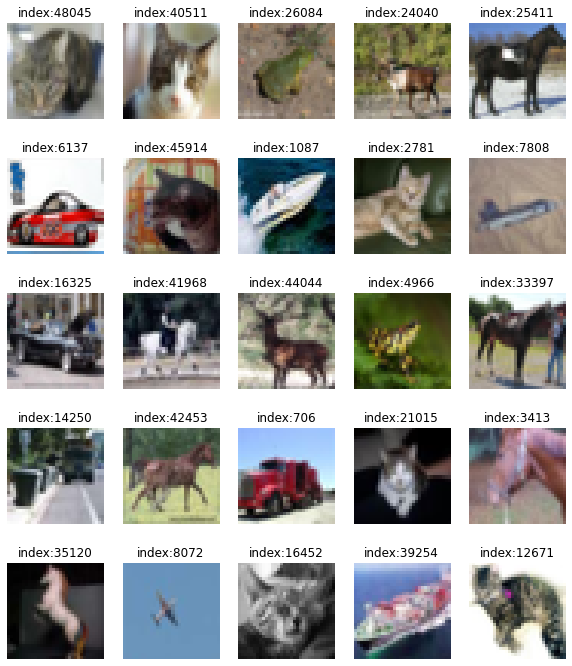

In [7]:
plt.figure(figsize=(10,12))

for i in range(25):
    plt.subplot(5,5,i+1)
    random = np.random.randint(len(train_x))
#     plt.imshow(train_x[random])
#     plt.imshow((train_x[random] * 255).astype(np.uint8))
    plt.imshow((train_x[random] * 127.5 +127.5).astype(np.int16))
    plt.title(f'index:{random}')
    plt.axis('off')
    
plt.show()


In [8]:
BUFFER_SIZE = 50000
BATCH_SIZE = 128

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = train_dataset.map(lambda x : tf.keras.layers.experimental.preprocessing.Resizing(64, 64)(x))
# train_dataset = train_dataset.map(lambda x : tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)(x))
print(len(train_dataset))

391


> 입력 이미지의 해상도를 높이기 위해 resizing 과 augmentation을 위한 코드를 작성하는 과정에서 <br>
>- 첫번째 시도 : generator model 안에 add.layer 를 통해 구현하려 했으나 갖은 오류를 만나고 실패
>- 두번째 시도 : train_dataset 에 map 함수와 lambda 표현식으로 구현하려 했으나 resizing 만 가능하고 randomrotation에서 오류 발생 
>- 세번째 시도 : image generater 를 import 해서 randomrotate 를 먼저 구현 한 후 resizing

In [9]:
def make_generator_model():
    
    # Start
    model = tf.keras.Sequential()
    
    
    # First : Dense Layer
    model.add(layers.Dense(16*16*256,use_bias=False,input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Second : Reshape Layer
    model.add(layers.Reshape((16,16,256)))
    
    # Third : Conv2DTanspose Layer
    model.add(layers.Conv2DTranspose(128,kernel_size=(5,5),strides=(2,2),padding='same',use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
   # Fifth : Conv2DTranspose Layer
    model.add(layers.Conv2DTranspose(3,kernel_size=(5,5),strides=(2,2),padding='same',use_bias=False,activation='tanh'))
    
    return model
    

In [10]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 65536)             6553600   
_________________________________________________________________
batch_normalization (BatchNo (None, 65536)             262144    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 65536)             0         
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 128)       819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 128)       0

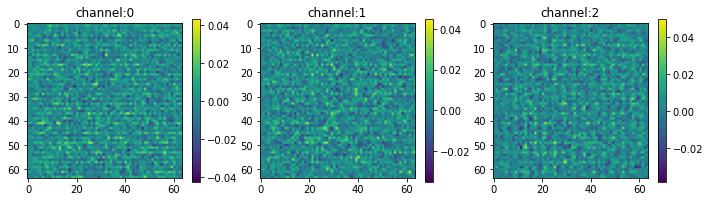

In [11]:
noise = tf.random.normal([1,100])
generated_image = generator(noise,training=False)
generated_image.shape

plt.figure(figsize=(16, 3))
for i in range(3) :
    plt.subplot(1, 4, i+1)
    plt.imshow(generated_image[0, :, :, i])
    plt.title("channel:{}".format(i))
    plt.colorbar()
plt.show()

In [12]:
def make_discriminator_model():
    
    # Start
    model = tf.keras.Sequential()
    
    # First : Conv2D Layer
    model.add(layers.Conv2D(64,(5,5),strides=(2,2),padding='same',input_shape=[64,64,3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Second : Conv2D Layer
    model.add(layers.Conv2D(128,(5,5),strides=(2,2),padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Third : Flatten Layer
    model.add(layers.Flatten())
    
    # Fourth : Dense Layer
    model.add(layers.Dense(1))
    
    return model

In [13]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 32768)            

In [14]:
decision = discriminator(generated_image,training=False) # training=False????????
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00340931]], dtype=float32)>

> generator 와 discriminator 의 layer 수를 모두 줄임.

> `decision = discriminator(generated_image,training=False)` 에서 `training_false`를 지우지 않으면 모델 학습이 돌아가지 않는 오류가 발생. 오류코드도 난생 처음 보는 코드. 나만 처음 보는 것도 아니고 많은 사람들에게 질문을 했지만, 다들 처음 보는 오류라고 말했다. 
> 이유를 알 수 없었으나, training=False 를 지우면 학습이 진행되어 처음에는 지우고 실행했다. 하지만 이후 지우지 않아도 실행이 되는 기현상이 일어났고 이 오류를 해결하기 위해 밤을 샌 나자신에 너무 화가 났고, 그 외에 건들인것도 없는 데 어떤날은 되고 어떤날은 되지 않는 내 코드에 매우 분노함을 느꼈다.

In [15]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [16]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)

In [17]:
def discriminator_loss(real_output,fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output),real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [18]:
def discriminator_accuracy(real_output,fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output,tf.constant([0.5])),tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output,tf.constant([0.5])),tf.float32))
    return real_accuracy,fake_accuracy

In [19]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [20]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate,noise_dim])
seed.shape

TensorShape([16, 100])

In [21]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE,noise_dim])
    
    with tf.GradientTape() as gen_tape,tf.GradientTape() as disc_tape:
        generated_images = generator(noise,training=True)
        
        real_output = discriminator(images,training=True)
        fake_output = discriminator(generated_images,training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output,fake_output)
        
        real_accuracy , fake_accuracy = discriminator_accuracy(real_output,fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss,generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss,discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator,generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,discriminator.trainable_variables))
    
    return gen_loss,disc_loss,real_accuracy,fake_accuracy

In [22]:
def generate_and_save_images(model,epoch,it,sample_seeds):
    
    predictions = model(sample_seeds,training=False)
    
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow((predictions[i,:,:,:]+1)/2)
        # normalization (?)
        plt.axis('off')
        
    # plt.savefig('/content/drive/MyDrive/data/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:03d}.png'.foramt(epoch,it))
#     plt.savefig('/content/drive/MyDrive/data/dcgan_newimage/cifar10/generated_samples/sample_epoch_' + str(epoch) + '.png')
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:03d}.png'.format(os.getenv('HOME'),epoch,it))
    plt.show()

> 학습을 진행하는 과정이 너무 오래걸려서, 다른 노드와 공부를 진행 할 수 없어 코랩으로 넘어가 시도를 했다. 엄청나게 많은 경로 문제를 마주쳤고, 겨우 해결을 해서 학습을 진행하게 되었는데, 진행 거의 다 돌아갔는데 조금만 더 하면 결과를 볼 수 있는데 gpu를 다썼다는 메세지로 다시한번 나에게 똥을 안겼다. 
경로문제 해결을 위해 들인 시간이 또 너무너무 아까웠지만 어쩔 수 없이 다시 주피터에서 처음부터 돌렸다. 주석처리 된 코드를 통해 그 과정을 짐작해 볼 수 있다.

In [23]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
#     plt.savefig('/content/drive/MyDrive/data/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'.format(epoch))
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [24]:
# checkpoint_dir = '/content/drive/MyDrive/data/dcgan_newimage/cifar10/training_checkpoints'
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir,'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                discriminator_optimizer=discriminator_optimizer,
                                generator=generator,
                                discriminator=discriminator)

In [25]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [26]:
save_every = 10
EPOCHS = 500

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

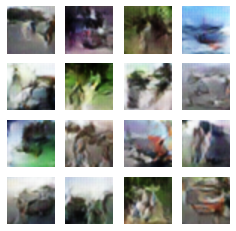

Time for training : 27167 sec


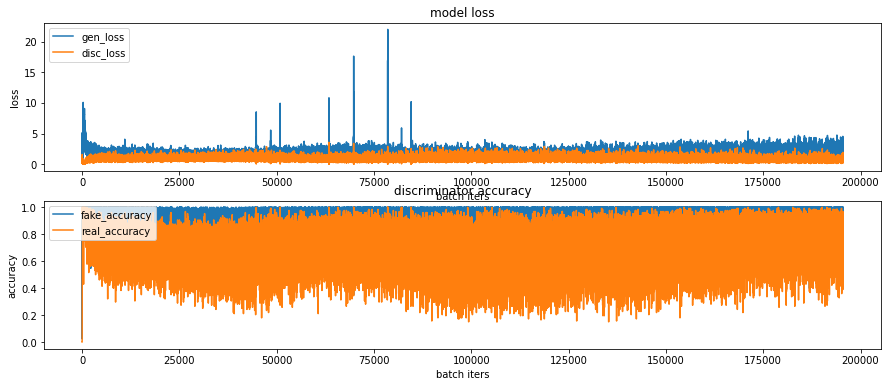

CPU times: user 7h 53min 6s, sys: 19min 4s, total: 8h 12min 10s
Wall time: 7h 32min 57s


In [27]:
%%time

train(train_dataset,EPOCHS,save_every)

> 대망의 학습 결과 : <br>
> - fake accuracy 는 여전히 내려가지 않았고, real accuracy 는 0.5 근처에 존재하기는 하지만, 진동의 폭이 너무 크다.
> - generator 를 통해 생성된 이미지도 기본 모델의 결과 보다 조금더 흐릿하게 보인다고 여겨지는 결과를 얻었다.


> 학습하는데 여덟시간이 넘는 시간이 걸렸고, 당연히 한번에 성공하지 못했다. 많은 사람들의 조언을 얻어 자기전에 실행 시켜놓고 잠들면, 다음날 아침 마법같이 결과를 받아 볼 수 있을 것이라 기대했지만, 우리의 클라우드는 6 시간에 한번씩 꺼진다. 물론 나의 클라우드는 여섯시간이 채 지나기도 전에 이유없이 자주 죽는다 개복치가 따로 없다. 
    그런 이유로, 여러번의 실패 후에 여덟시간동안 노트북 앞에 가만히 앉아서 커널이 죽지 않게 지켰다. 그랬는데 실망스러운 결과로 어김없이 나에게 똥을 안겼다. 배은망덕한 자식
    
> 더이상은 시간적으로나 정신적으로나 다시 모델을 개선하고 다시 학습을 시킬 의지를 잃었다. 물론 이 모델로 첫 시도를 해보고 바로 포기한 것은 아니다. 그간 정말 다양한 시도를 해 보았다. 모델을 더 깊게 쌓아본 버전, augmentation없이 입력 이미지 사이즈만 늘린 버전, 에폭을 줄여보기도 늘려보기도 했고, optimizer 를 변형 해 보기도 했다. 모든 버전을 기록하고 이번엔 이랬고, 저랬다 라고적지 않은채 같은 모델을 수정에 수정을 거듭했을 뿐이다. 내가 이러이러한 시도를 했음을 보여주기 위해 그 모든 버전의 모델을 다시 만들고 기록으로 남길 의지 또한 없기에, 이러이러한 것을 시도해 보았음 이라고만 글로 적겠다. 

### 회고 :
이번 한주 내내 이 과제로 인해 다른 과제는 전혀 처다도 못봤고 노드 왕창 밀린 사람이 되었다. 한주간 많이 짜증내고 화냈으며 많이 울기도 했다. 많은 분들이 내 걱정을 해주셨고, 도움을 주려고 하셨던걸 알고 있으며 굉장히 감사히 생각하고 있다. 솔직한 심정으로는 다시는 처다도 보고 싶지 않다. 다 내 능력이 부족한 탓이지만,
현실적인 나의 수준에서 개선된 gan 모델을 일주일 내로 만들기엔 역부족이며, 한달정도 주면 더 많이 울겠지만, 아마 가능 할 지도 모르겠다. 너무너무 힘들었고 정신이 피폐해지는 걸 실시간으로 느꼈다.
그러나 멀지 않은 미래에 훨씬 똑똑해진 내가 이 글을 보고 이걸 못해서 이러고 있었다니 하며 과거의 나를 한심하며 부끄러워 하는 날이 오기를 바란다.